This notebook contains all the code needed to automatically calculate the Facial-Width-Height ratio based on an image using the `face_recognition` package.  
**See: https://github.com/ageitgey/face_recognition**

# Preamble

## Imports

In [5]:
import math
import os
import pandas as pd

from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import face_recognition

import urllib.request 

# Main Code

### Function to load an image

This function loads an image from the drive or downloads it from a link if `url` is set to `True`.

In [10]:
def load_image(path, url=False):
    if not url:
        return face_recognition.load_image_file(path)
    else:
        if path[-3:] == 'jpg' or  path[-3:] == 'peg':
            urllib.request.urlretrieve(path, 'tmp.jpg')
            return face_recognition.load_image_file('tmp.jpg')
        elif path[-3:] == 'png':
            urllib.request.urlretrieve(path, 'tmp.png')
            return face_recognition.load_image_file('tmp.png')
        else:
            print("Unknown image type")

### Function to get the contour face points

This function calculates the coordinates for the corners of the "FWHR" box.  
*Note 1:* it is possible to calculate the top line based on either the bottom of the eyebrows (`top = "eyebrow"`) or the eyelids (`top = "eyelid"`).  
*Note 2:* to counter-act small amounts of rotation it will by default take the average between the height of the two top points.

In [14]:
def get_face_points(points, method='average', top='eyebrow'):
    width_left, width_right = points[0], points[16]
    
    if top == 'eyebrow':
        top_left = points[18]
        top_right = points[25]
        
    elif top == 'eyelid':
        top_left = points[37]
        top_right = points[43] 
        
    else:
        raise ValueError('Invalid top point, use either "eyebrow" or "eyelid"')
        
    bottom_left, bottom_right = points[50], points[52]
    
    if method == 'left':
        coords = (width_left[0], width_right[0], top_left[1], bottom_left[1])
        
    elif method == 'right':
        coords = (width_left[0], width_right[0], top_right[1], bottom_right[1])
        
    else:
        top_average = int((top_left[1] + top_right[1]) / 2)
        bottom_average = int((bottom_left[1] + bottom_right[1]) / 2)
        coords = (width_left[0], width_right[0], top_average, bottom_average)
        
    ## Move the line just a little above the top of the eye to the eyelid    
    if top == 'eyelid':
        coords = (coords[0], coords[1], coords[2] - 4, coords[3])
        
    return {'top_left' : (coords[0], coords[2]),
            'bottom_left' : (coords[0], coords[3]),
            'top_right' : (coords[1], coords[2]),
            'bottom_right' : (coords[1], coords[3])
           }

### Function to check suitability of picture

This function checks whether a picture contains a person that is looking straight at the camera.

In [18]:
def good_picture_check(p, debug=False):
    ## To scale for picture size
    width_im = (p[16][0] - p[0][0]) / 100
    
    ## Difference in height between eyes
    eye_y_l = (p[37][1] + p[41][1]) / 2.0
    eye_y_r = (p[44][1] + p[46][1]) / 2.0
    eye_dif = (eye_y_r - eye_y_l) / width_im
    
    ## Difference top / bottom point nose 
    nose_dif = (p[30][0] - p[27][0]) / width_im
    
    ## Space between face-edge to eye, left vs. right
    left_space = p[36][0] - p[0][0]
    right_space = p[16][0] - p[45][0]
    space_ratio = left_space / right_space
    
    if debug:
        print(eye_dif, nose_dif, space_ratio)
    
    ## These rules are not perfect, determined by trying a bunch of "bad" pictures
    if eye_dif > 5 or nose_dif > 3.5 or space_ratio > 3:
        return False
    else:
        return True

### Function to calculate the FWHR

This function calculates the FWHR based on the corners: `Width / Height`

In [22]:
def FWHR_calc(corners):
    width = corners['top_right'][0] - corners['top_left'][0]
    height = corners['bottom_left'][1] - corners['top_left'][1]
    return float(width) / float(height)

### Function to show the FWHR box on the image

This function shows the FWHR box on the original image.

In [26]:
def show_box(image, corners):
    pil_image = Image.fromarray(image)
    w, h = pil_image.size
    
    ## Automatically determine width of the line depending on size of picture
    line_width = math.ceil(h / 100)
    
    d = ImageDraw.Draw(pil_image) 
    d.line([corners['bottom_left'], corners['top_left']], width = line_width)
    d.line([corners['bottom_left'], corners['bottom_right']], width = line_width)
    d.line([corners['top_left'], corners['top_right']], width = line_width)
    d.line([corners['top_right'], corners['bottom_right']], width = line_width)
    
    imshow(pil_image)

### Final function that combines the previous functions

This function combines all the previous logic into one function.  

Arguments:

`image_path` $\rightarrow$ path or URL to image  
`url` $\rightarrow$ set to `True` if `image_path` is a url  
`show` $\rightarrow$ set to `False` if you only want it to return the FWHR  
`method` $\rightarrow$ determines which eye to use for the top point: `left`, `right`, or `average`  
`top` $\rightarrow$ determines whether to use the `eyebrow` as top point or `eyelid` as top point  


In [30]:
def get_fwhr(image_path, url=False, show=True, method='average', top='eyelid'):
    image = load_image(image_path, url)
    landmarks = face_recognition.api._raw_face_landmarks(image)
    landmarks_as_tuples = [(p.x, p.y) for p in landmarks[0].parts()]
    
    if good_picture_check(landmarks_as_tuples): 
        corners = get_face_points(landmarks_as_tuples, method=method, top = top)
        fwh_ratio = FWHR_calc(corners)
        
        if show:
            print('The Facial-Width-Height ratio is: {}'.format(fwh_ratio))
            show_box(image, corners)
        else:
            return fwh_ratio
    else:
        if show:
            print("Picture is not suitable to calculate fwhr.")
            imshow(image)
        else:
            return None

# fWHR
<a id='fwhr calculator'></a>

In [ ]:
rep1 = 'path_to_image/US_politician.jpeg'

The Facial-Width-Height ratio is: 1.7585034013605443


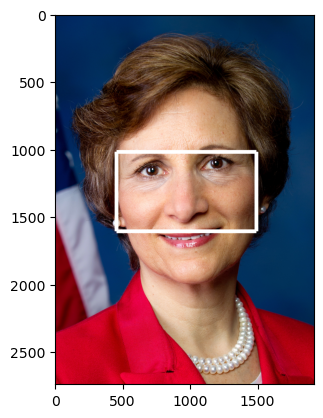

In [44]:
get_fwhr(rep1, url=False, top = 'eyebrow', show=True)

In [ ]:
# List of directories to search for image files and results
directories = [
    'user/directory1_to_the_images',
    'user/directory2_to_the_images',
    'user/directory3_to_the_images',
    'user/directory4_to_the_images',
]
results = []

In [ ]:
total_files = 0
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith('.jpeg') or filename.endswith('.jpg'):
            total_files += 1
processed_files = 0

for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith('.jpeg') or filename.endswith('.jpg'):
            filepath = os.path.join(directory, filename)
            
            eyebrow_fwhr = get_fwhr(filepath, url=False, top='eyebrow', show=False)
            eyelid_fwhr = get_fwhr(filepath, url=False, top='eyelid', show=False)
            
            results.append({
                'filename': filename,
                'eyebrow_fwhr': eyebrow_fwhr,
                'eyelid_fwhr': eyelid_fwhr
            })
            
            processed_files += 1
           print(f"Processed {processed_files}/{total_files} files... ({filename})")

Processed 1/3035 files... (Vern_Buchanan.jpeg)
Processed 2/3035 files... (Michael_Burgess.jpeg)
Processed 3/3035 files... (Nick_Lalota.jpeg)
Processed 4/3035 files... (Robert_Scott.jpeg)
Processed 5/3035 files... (David_Kustoff.jpeg)
Processed 6/3035 files... (Jared_Huffman.jpeg)
Processed 7/3035 files... (William_Timmons.jpeg)
Processed 8/3035 files... (Joe_Neguse.jpeg)
Processed 9/3035 files... (Barry_Loudermilk.jpeg)
Processed 10/3035 files... (Andy_Biggs.jpeg)
Processed 11/3035 files... (Doris_Matsui.jpeg)
Processed 12/3035 files... (Suzanne_Bonamici.jpeg)
Processed 13/3035 files... (Tony_Cárdenas.jpeg)
Processed 14/3035 files... (Ashley_Hinson.jpeg)
Processed 15/3035 files... (Daniel_Webster.jpeg)
Processed 16/3035 files... (Michael_Cloud.jpeg)
Processed 17/3035 files... (Al_Green.jpeg)
Processed 18/3035 files... (Jim_Himes.jpeg)
Processed 19/3035 files... (Mike_Levin.jpeg)
Processed 20/3035 files... (John_Garamendi.jpeg)
Processed 21/3035 files... (Brandon_Williams.jpeg)
Process

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 37/3035 files... (Pat_Fallon.jpeg)
Processed 38/3035 files... (Melanie_Stansbury.jpeg)
Processed 39/3035 files... (Young_Kim.jpeg)
Processed 40/3035 files... (Marcus_Molinaro.jpeg)
Processed 41/3035 files... (Abigail_Spanberger.jpeg)
Processed 42/3035 files... (Andrew_Clyde.jpeg)
Processed 43/3035 files... (Nydia_Velázquez.jpeg)
Processed 44/3035 files... (Mary_Peltola.jpeg)
Processed 45/3035 files... (Val_Hoyle.jpeg)
Processed 46/3035 files... (John_Larson.jpeg)
Processed 47/3035 files... (Gerald_Connolly.jpeg)
Processed 48/3035 files... (Don_Davis.jpeg)
Processed 49/3035 files... (Stephen_Lynch.jpeg)
Processed 50/3035 files... (Darrell_Issa.jpeg)
Processed 51/3035 files... (Scott_DesJarlais.jpeg)
Processed 52/3035 files... (Nathaniel_Moran.jpeg)
Processed 53/3035 files... (Chellie_Pingree.jpeg)
Processed 54/3035 files... (Rashida_Tlaib.jpeg)
Processed 55/3035 files... (Rich_McCormick.jpeg)
Processed 56/3035 files... (Brad_Finstad.jpeg)
Processed 57/3035 files... (Jim_Jorda

In [116]:
# Create a DataFrame from the results
df = pd.DataFrame(results)

In [118]:
# Save the DataFrame to a CSV file
output_csv = '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/FWHR/fwhr_results.csv'
df.to_csv(output_csv, index=False)

print(f"Results saved to {output_csv}")

Results saved to /Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/FWHR/fwhr_results.csv


In [142]:
import os
import pandas as pd

# List of directories to search for image files
directories = [
    '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/Congress/118th/Photo/Official',
    '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/Congress/117th/Photo/Official',
    '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/Congress/116th/Photo/Official',
    '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/Congress/115th/Photo/Official',
    '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/Congress/114th/Photo/Official',
    '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/Congress/113th/Photo/Official',
    '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/Congress/112th/Photo/Official'
]

# Create a dictionary to map full file paths to their respective folder names
file_to_folder = {}

for directory in directories:
    folder_name = os.path.basename(os.path.dirname(os.path.dirname(directory)))  # Get the 118th, 117th, etc.
    for filename in os.listdir(directory):
        if filename.endswith('.jpeg') or filename.endswith('.jpg'):
            full_path = os.path.join(directory, filename)
            file_to_folder[filename] = folder_name

# Load the existing CSV file
csv_file = '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/FWHR/fwhr_results.csv'
df = pd.read_csv(csv_file)

# Add the folder name column based on the file_to_folder mapping
df['folder'] = df['filename'].map(file_to_folder)

# Save the updated DataFrame to a new CSV file
output_csv = '/Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/FWHR/fwhr_results_with_folders.csv'
df.to_csv(output_csv, index=False)

print(f"Updated results saved to {output_csv}")

Updated results saved to /Users/robertovacante/Documents/Altro/Road_to_PhD/RAs/Nicola Persico/Data Generating/FWHR/fwhr_results_with_folders.csv
